In [68]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
df = pd.read_csv('AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
df.shape

(10000, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


### У нас 10000 непропущенных значений. Проверим уникальность пользователей

In [5]:
df.USER_ID.nunique()

6324

### Получается, что у нас 3676 повторных пользователей. Посмотрим теперь, есть ли пользователи, которые попали в обе группы

In [6]:
double_group = df.groupby(by = 'USER_ID').VARIANT_NAME.nunique().value_counts() 
double_group

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [7]:
double_group / double_group.sum()

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64

### Около 24% пользователей попали в обе группы. Удалим их

In [8]:
duplicate = df.groupby(by = 'USER_ID').VARIANT_NAME.nunique() == 2

In [9]:
duplicate = duplicate[duplicate].index
duplicate

Int64Index([    3,    10,    18,    25,    40,    57,    60,    64,    67,
               86,
            ...
             9933,  9940,  9942,  9961,  9973,  9978,  9979,  9982,  9996,
            10000],
           dtype='int64', name='USER_ID', length=1541)

In [10]:
df_new = df[~df.USER_ID.isin(duplicate)]
df_new

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [11]:
df_new.nunique()

USER_ID         4783
VARIANT_NAME       2
REVENUE           70
dtype: int64

### Количество уникальных пользователей, которые попали в одну группу совпали

In [12]:
df = df_new

### Посмотрим, как распределены данные

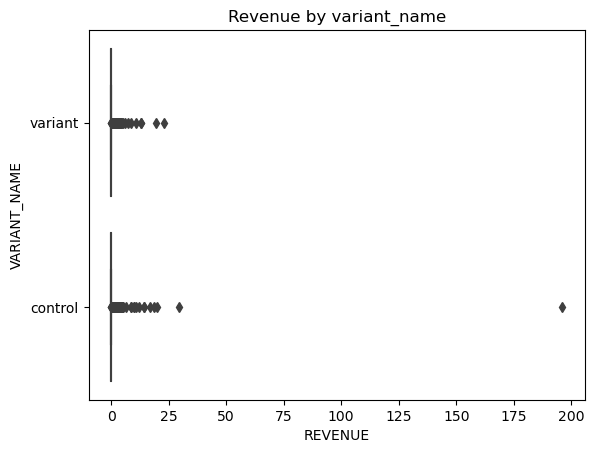

In [13]:
sns.boxplot(x = 'REVENUE', y = 'VARIANT_NAME', data = df, orient = 'h').set(title = 'Revenue by variant_name');

### Мы видим значительный выброс, который может быть ошибкой данных, оптовой закупкой и т.д. Так как такой выброс один, то просто удалим его

In [14]:
df = df[df.REVENUE < 150]

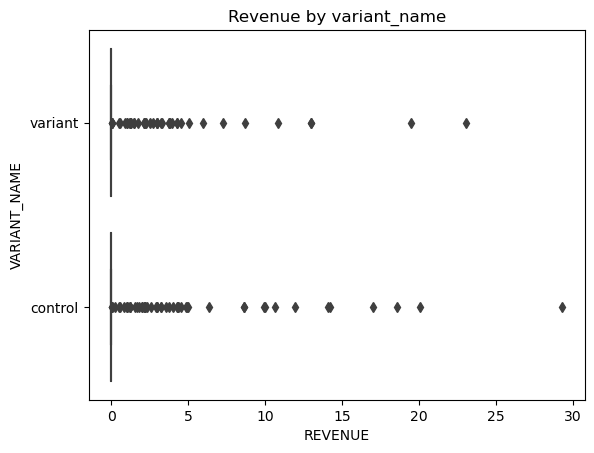

In [15]:
sns.boxplot(x = 'REVENUE', y = 'VARIANT_NAME', data = df, orient = 'h').set(title = 'Revenue by variant_name');

### Большинство пользователей не совершают покупки, посмотрим график для пользователей, которые совершают покупки

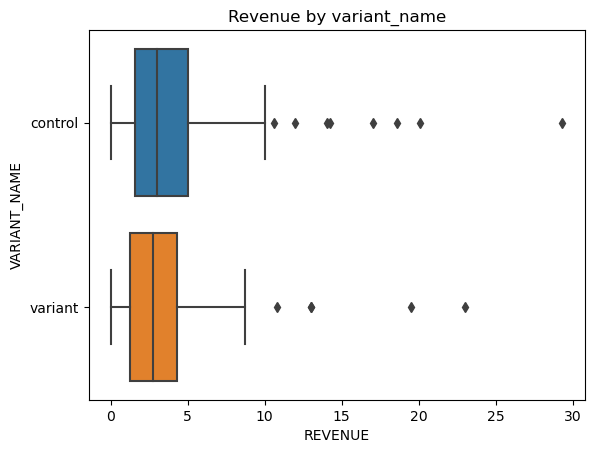

In [16]:
sns.boxplot(x = 'REVENUE', y = 'VARIANT_NAME', data = df[df.REVENUE > 0], orient = 'h').set(title = 'Revenue by variant_name');

### Посмотрим на основные показатели для всех пользователей и для пользователей, которые совершают покупки

In [17]:
# Все пользователи

df.groupby(by = 'VARIANT_NAME').agg({'USER_ID': [('total', len),'nunique','count'], 'REVENUE':['sum', 'median', 'mean']})

USER_ID               REVENUE                 
               total nunique count     sum median      mean
VARIANT_NAME                                               
control         3025    2389  3025  274.55    0.0  0.090760
variant         3044    2393  3044  179.32    0.0  0.058909

In [18]:
# Пользователи совершающие покупки

df[df.REVENUE > 0].groupby(by = 'VARIANT_NAME').agg({'USER_ID': [('total', len),'nunique','count'], 'REVENUE':['sum', 'median', 'mean']})

USER_ID               REVENUE                 
               total nunique count     sum median      mean
VARIANT_NAME                                               
control           53      53    53  274.55   2.99  5.180189
variant           43      42    43  179.32   2.72  4.170233

#### Можно сделать выводы, что в контрольной группе выручка по пользователям больше (проверим это статистическим анализом), следовательно как и средняя с медианой

## Статистический анализ

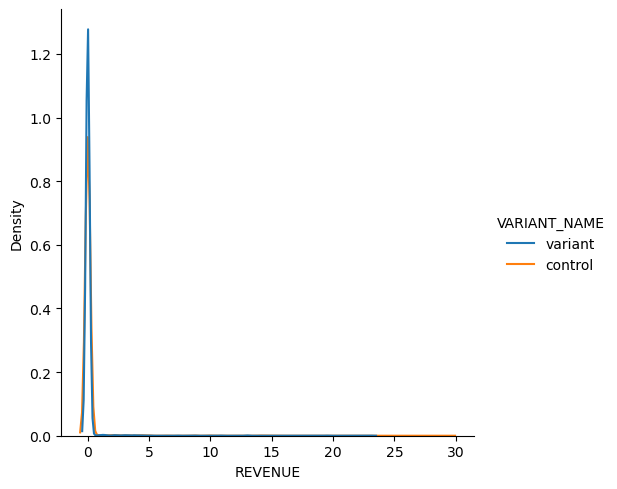

In [19]:
sns.displot(data=df, x='REVENUE', hue='VARIANT_NAME', fill = False, kind = 'kde');

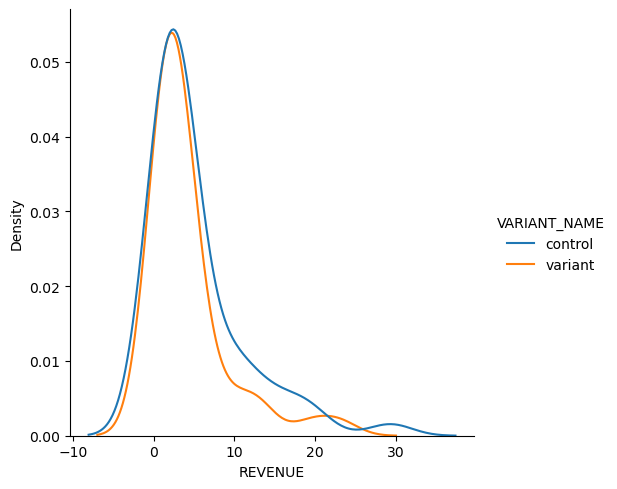

In [20]:
sns.displot(data = df[df.REVENUE > 0], x='REVENUE', hue='VARIANT_NAME', fill = False, kind = 'kde');

#### По распределению мы можем смело сказать, что оно не является нормальным, но для чистоты анализа проведем тест на нормальность Шапиро-Уилка. Уровень значимости возьмем 5%

    - H0: данные распределены нормально 
    - H1: данные распределены ненормально

In [21]:
a = 0.05
for i in df.VARIANT_NAME.unique():
    x = stats.shapiro(df.loc[df.VARIANT_NAME == i, 'REVENUE'])[1]
    if x > 0.05:
        print(f'Данные из группы {i} распределены нормально')
    else:
        print(f'Данные из группы {i} распределены ненормально')

Данные из группы variant распределены ненормально
Данные из группы control распределены ненормально


#### Так как наши данные имеют не нормальное распределение, а также независимы, так как мы убрали пользователей, которые попадали в обе группы, то мы можем применить тест Манна-Уитни. Уровень значимость 5%

    - H0: пользователи из контрольной группы приносят такой же доход, как и в альтернативной (распределения равны)
    - H1: пользователи из контрольной группы приносят больший доход, чем пользователи из альтернативной

In [22]:
stats.mannwhitneyu(df[df.VARIANT_NAME == 'control'].REVENUE, df[df.VARIANT_NAME == 'variant'].REVENUE, alternative = 'greater')

MannwhitneyuResult(statistic=4619788.0, pvalue=0.1429921154309774)

### P-value > 0.05, поэтому мы не может отвергнуть нулевую гипотезу.
### Делаем вывод, что пользователи из контрольной группы приносят такой же доход, как и в альтернативной

## Bootstrap

#### Проверим гипотезу равенства среднего в двух группа бутстрапированием

In [25]:
variant = df[df['VARIANT_NAME'] == 'variant']
variant.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
14,3489,variant,0.0
16,7549,variant,0.0


In [27]:
control = df[df['VARIANT_NAME'] == 'control']
control.head()

,USER_ID,VARIANT_NAME,REVENUE
7,9168,control,0.0
9,7548,control,0.0
10,8395,control,0.0
11,1184,control,0.0
12,7165,control,0.0


#### Если нуль попадет в доверительный интервал 95%, то можно будет сказать, что нет разницы между средним в двух группах

    -H0: разница между средними в двух группах равна 0
    -H1: разница между средними в двух группах не равна 0

In [31]:
diffs = []
for _ in range(10000):
    sample_variant = variant.sample(variant.shape[0], replace = True)
    sample_control = control.sample(control.shape[0], replace = True)
    mean_diff = sample_variant.REVENUE.mean() - sample_control.REVENUE.mean()
    diffs.append(mean_diff)

In [53]:
left_bound = np.percentile(diffs, 2.5)
right_bound = np.percentile(diffs, 97.5)

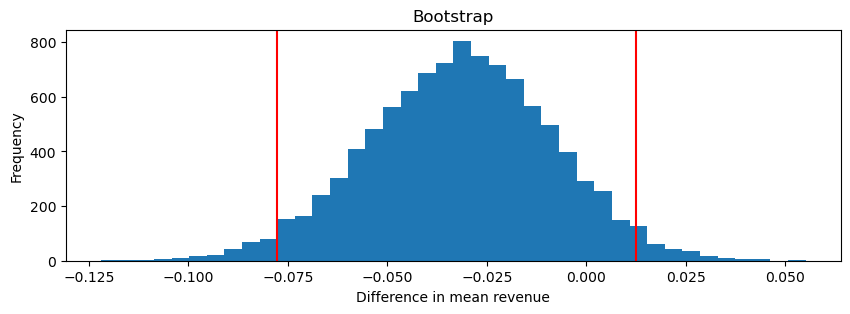

Lower bound: -0.07774732659289105
Upper bound: 0.012586891758343181


In [56]:
fig = plt.figure(figsize = (10,3))
ax = plt.hist(diffs, bins = 40)
plt.axvline(left_bound, color = 'r')
plt.axvline(right_bound, color = 'r')
plt.ylabel('Frequency')
plt.xlabel('Difference in mean revenue')
plt.title('Bootstrap')
plt.show()
print('Lower bound:',left_bound)
print('Upper bound:', right_bound)

### В доверительный интервал попал 0, значит мы можем сказать, что разницы между средними нет
### Поверим это еще с помощью z-теста

In [72]:
sm.stats.ztest(control.REVENUE, variant.REVENUE)

(1.367590650018532, 0.17144024477597197)

### P-value больше нашего уровня значимости в 0.05, поэтому мы не можем отвергнуть нулевую гипотезу